# Image Classification With Neural Networks

## Scott Stempak, Alex Imhoff

In [15]:
import torch
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

### Load and Setup the Dataset

In [16]:
#Define transformation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

#load data
dataset = datasets.ImageFolder(root = 'data/EuroSAT_RGB', transform = transform)

#train-test split 80/20
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = False)

### Define the Neural Network

In [17]:
##Defining the NN
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.fc1 = nn.Linear(32 * 14 * 14, 256)
    self.fc2 = nn.Linear(256, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x)) #conv1 & relu 
    x = F.max_pool2d(x, 2, 2) #max pool
    x = F.relu(self.conv2(x)) #conv2 & relu
    x = F.max_pool2d(x, 2, 2) #max pool
    
    x = torch.flatten(x, 1) #flatten

    x = F.relu(self.fc1(x)) #fc layer 1 & relu
    x = self.fc2(x)         #fc layer 2
    
    return x

In [18]:
#Define Loss Function, Optimizer, and NN
net = SimpleCNN()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

### Train the Model

In [19]:
#Train the model
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0
    for data in train_loader:
        inputs, labels = data
        optimizer.zero_grad()
        predictions = net(inputs) 
        loss = criterion(predictions, labels)
        loss.backward()  
        optimizer.step()
        running_loss += loss.item()
        
    print(f'Epoch {epoch+1} complete. Running loss: {running_loss}')
    print()

Epoch 1 complete. Running loss: 205.52186393737793

Epoch 2 complete. Running loss: 126.79034972190857

Epoch 3 complete. Running loss: 110.86439183354378

Epoch 4 complete. Running loss: 94.71457549929619

Epoch 5 complete. Running loss: 85.97050186991692

Epoch 6 complete. Running loss: 77.78705909848213

Epoch 7 complete. Running loss: 69.32331125438213

Epoch 8 complete. Running loss: 63.3936510682106

Epoch 9 complete. Running loss: 57.8187113404274

Epoch 10 complete. Running loss: 50.80671827495098



### Evaluation

In [20]:
#Evalute the model
def evaluate(net, test_loader):
  net.eval()
  correct = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for data, target in test_loader:
      prediction = net(data)
      pred = prediction.argmax(dim = 1, keepdim = True)
      correct += pred.eq(target.view_as(pred)).sum().item()
      all_preds.extend(pred.cpu().numpy())
      all_labels.extend(target.cpu().numpy())

    accuracy = correct / len(test_loader.dataset)
    return accuracy, np.array(all_preds), np.array(all_labels)

accuracy, preds, labels = evaluate(net, test_loader)
#make confusion matrix for later display
cm = confusion_matrix(labels, preds)

### Overall Test-Set Accuracy

In [21]:
print(f'Test set accuracy: {accuracy * 100:.2f}%')

Test set accuracy: 82.98%


### Example images from the test set with my model's predicted classes

I first print out the images of one test batch (128 images) which is in the form of 16 rows of 8 images. I then print the predictions below in the same format (16 rows of 8 predictions). This allows you to read it as the image and prediction in the same spot (first image in row 1's prediction is the first prediction in row one).

Finally, I display the accuracy for the predictions on this specific test batch below my predictions.

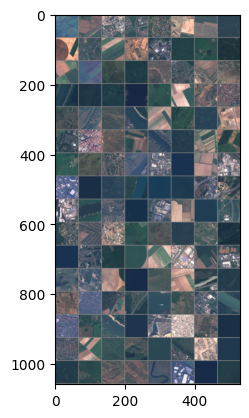

Predicted:
Pasture AnnualCrop Industrial Highway Residential PermanentCrop AnnualCrop Forest
AnnualCrop Residential AnnualCrop PermanentCrop Industrial Forest Pasture Forest
AnnualCrop River HerbaceousVegetation Forest HerbaceousVegetation Residential PermanentCrop HerbaceousVegetation
River Forest Forest SeaLake Pasture AnnualCrop PermanentCrop Residential
HerbaceousVegetation River HerbaceousVegetation River AnnualCrop Forest Forest PermanentCrop
Highway Residential HerbaceousVegetation AnnualCrop River Forest Highway AnnualCrop
Pasture HerbaceousVegetation Residential River Industrial SeaLake AnnualCrop Industrial
Industrial SeaLake Forest River SeaLake SeaLake Residential Highway
Industrial River Residential SeaLake Industrial AnnualCrop SeaLake River
Residential HerbaceousVegetation PermanentCrop Pasture HerbaceousVegetation Forest PermanentCrop Forest
SeaLake Highway Forest Pasture AnnualCrop Industrial AnnualCrop Industrial
River Highway AnnualCrop SeaLake HerbaceousVegetation A

In [22]:
#Visualize Results
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)

#get preds
outputs = net(images)
_, predicted = torch.max(outputs, 1)

#show images with pred labels
imshow(utils.make_grid(images))
print('Predicted:')
for i in range(16):
  print(' '.join(f'{dataset.classes[predicted[j]]}'for j in range(i*8, (i+1)*8)))

#evaluation
correct = (predicted == labels).sum().item()
total = labels.size(0)
accuracy = 100 * correct / total
print()
print(f'Accuracy of my neural network on this test batch is {accuracy:.2f}%')

### Confusion Matrix

note: I initialized the confusion matrix in the evaluation section of the code since I redeclare some variable names for the visualizing the images and making more predictions in the section above.

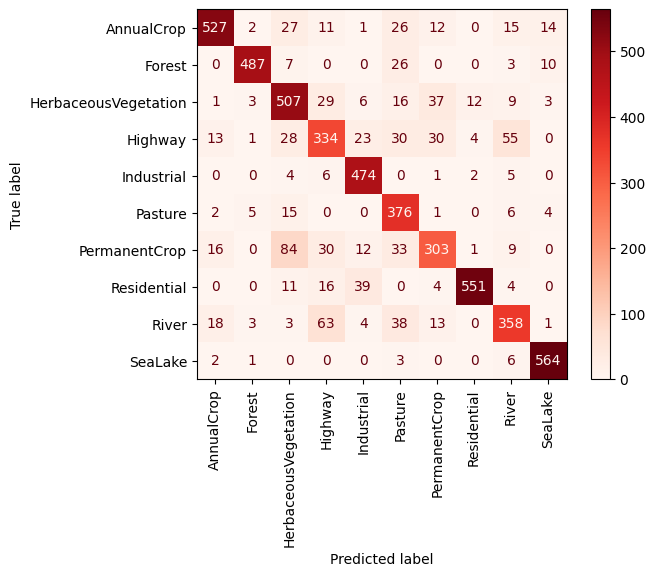

In [23]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = dataset.classes)

disp.plot(cmap=plt.cm.Reds)
plt.xticks(rotation = 90);